In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import numpy as np
import csv
import os
from tqdm import tqdm
from collections import defaultdict
import sys
import warnings
warnings.filterwarnings("ignore")
csv.field_size_limit(sys.maxsize)
from matplotlib.patches import Patch
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
def get_csv_paths(folder_path, recursive=False):
    if recursive:
        # Walk through all subdirectories
        file_paths = [os.path.join(root, file) 
                      for root, _, files in os.walk(folder_path) 
                      for file in files if file.endswith('.csv')]
    else:
        # Get files in the root folder only
        file_paths = [os.path.join(folder_path, file) 
                      for file in os.listdir(folder_path) 
                      if file.endswith('.csv')]
    
    return file_paths

In [3]:
paths_ai = get_csv_paths("../data/ngrams/data_ai/", recursive=True)
paths_human = get_csv_paths("../data/ngrams/data_human/")
paths = paths_ai + paths_human
len(paths)

220

In [4]:
def top5_ngrams_by_n(filepath, n_rows=5):
    data = filepath.split("/")[-1].split("_")[0]
    model = filepath.split("/")[-1].split("_")[1]
    
    results = defaultdict(list)
    totals = defaultdict(int)

    with open(filepath, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            ngram = row['ngram']
            n = int(row['n'])
            freq = int(row['frequency'])

            if any(word.lower() in stop_words for word in ngram.split()):
                continue  # skip this ngram

            # count this ngram occurrence for total tracking
            totals[n] += freq

            # collect top n_rows items only (file is pre-sorted)
            if len(results[n]) < n_rows:
                results[n].append((ngram, freq))

    return data, model, results, totals

In [5]:
def save_combined_results_to_csv(data, model, results, totals, output_path='ngrams_summary.csv'):
    rows = []
    for n in sorted(results.keys()):
        total = totals.get(n, 0)
        for rank, (ngram, freq) in enumerate(results[n], start=1):
            rows.append({
                'n': n,
                'rank': rank,
                'ngram': ngram,
                'frequency': freq,
                'total_ngrams': total
            })

    df = pd.DataFrame(rows)
    df["data"] = data
    df['model'] = model
    # save if no output exists, if exists, append
    if not os.path.exists(output_path):
        df.to_csv(output_path, index=False)
    else:
        df.to_csv(output_path, mode='a', header=False, index=False)

In [8]:
for path in tqdm(paths):
    data, model, results, totals = top5_ngrams_by_n(path, n_rows=100)
    save_combined_results_to_csv(data, model, results, totals, output_path='ngrams_summary.csv')

100%|██████████| 220/220 [1:47:43<00:00, 29.38s/it] 


In [9]:
df = pd.read_csv("ngrams_summary.csv")
df["is_human"] = df["model"].apply(lambda x: 1 if x == "human" else 0)
df.head()

,n,rank,ngram,frequency,total_ngrams,data,model,is_human
0,1,1,time,23699,4392204,blogs,Llama-3.2-3B-Instruct,0
1,1,2,life,21837,4392204,blogs,Llama-3.2-3B-Instruct,0
2,1,3,day,18508,4392204,blogs,Llama-3.2-3B-Instruct,0
3,1,4,one,18274,4392204,blogs,Llama-3.2-3B-Instruct,0
4,1,5,like,17864,4392204,blogs,Llama-3.2-3B-Instruct,0


In [14]:
n = 3
i = 0
tmp2 = df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)].groupby("ngram").sum().reset_index()
tmp2["normalized_frequency"] = tmp2["frequency"] / (df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)]["total_ngrams"].sum() / 10)

In [29]:
tmp2.sort_values("normalized_frequency", ascending=False).iloc[160:]

,ngram,n,rank,frequency,total_ngrams,data,model,is_human,normalized_frequency
1357,tv tv tv,3,28,4109,1252808,blogs,Phi-3-medium-128k-instruct,0,2.645983e-05
429,fork fork fork,3,30,4091,1252808,blogs,Phi-3-medium-128k-instruct,0,2.634391e-05
1287,switzerland switzerland switzerland,3,31,4087,1252808,blogs,Phi-3-medium-128k-instruct,0,2.631816e-05
512,happy birthday jay,3,13,4076,632262,blogs,Ministral-8B-Instruct-2410,0,2.624732e-05
129,birthday jay happy,3,14,4075,632262,blogs,Ministral-8B-Instruct-2410,0,2.624088e-05
...,...,...,...,...,...,...,...,...,...
269,craving wings tonight,3,93,24,550959,blogs,phi-4,0,1.545475e-07
165,brings back memories,3,94,24,465275,blogs,Qwen2.5-72B-Instruct-AWQ,0,1.545475e-07
1479,yuck yuck yuck,3,94,24,550959,blogs,phi-4,0,1.545475e-07
1383,uri new uri,3,98,23,550959,blogs,phi-4,0,1.481081e-07


In [11]:
idx = {"blogs": 0, "xsum": 6}

In [120]:
datas

array(['blogs', 'essays', 'natural-questions', 'nyt-articles',
       'nyt-comments', 'raid', 'reddit', 'tweets', 'writingprompts',
       'xsum'], dtype=object)

In [12]:
datas_names = ["Blogs", "Essays", "Natural Questions", "NYT Articles", "NYT Comments", "RAID", "Reddit", "Tweets", "WritingPrompts", "XSum"]
datas = df["data"].sort_values().unique()

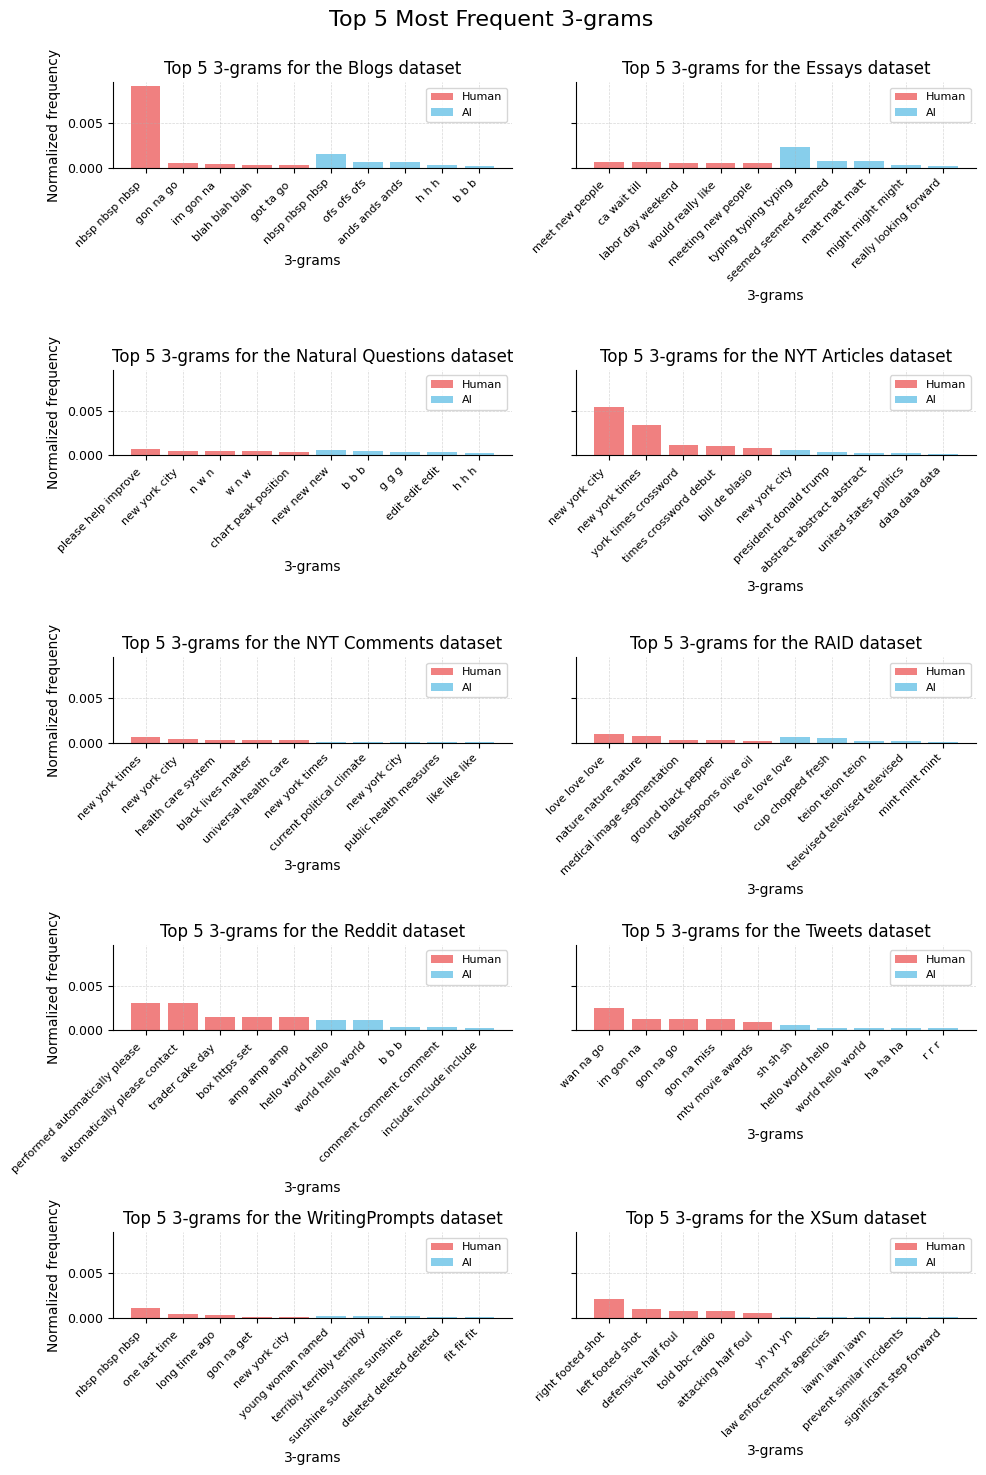

In [13]:
n = 3
fig, axes = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    
    tmp1 = df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 1)]
    tmp1["normalized_frequency"] = tmp1["frequency"] / tmp1["total_ngrams"]
    tmp1 = tmp1.nlargest(5, "normalized_frequency")
    tmp1["ngram"] = tmp1["ngram"]  + " "

    tmp2 = df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)].groupby("ngram").sum().reset_index()
    tmp2["normalized_frequency"] = tmp2["frequency"] / (df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)]["total_ngrams"].sum() / 10)
    tmp2 = tmp2.nlargest(5, "normalized_frequency")
    tmp = pd.concat([tmp1, tmp2], ignore_index=True)
    colors = tmp['is_human'].map({0: 'skyblue', 1: 'lightcoral'})

    ax.bar(tmp['ngram'], tmp['normalized_frequency'], color=colors)
    ax.set_title(f"Top 5 {n}-grams for the {datas_names[i]} dataset", fontsize=12)
    ax.set_xlabel(f"{n}-grams", fontsize=10)
    ax.set_xticks(range(len(tmp['ngram'])))  # Ensure ticks match bar positions
    ax.set_xticklabels(tmp['ngram'], rotation=45, ha='right', fontsize=8)
    if i % 2 == 0:
        ax.set_ylabel("Normalized frequency", fontsize=10)
        ax.tick_params(axis='y', labelsize=9)
    
    ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    legend_elements = [
        Patch(facecolor='lightcoral', label='Human'),
        Patch(facecolor='skyblue', label='AI')
    ]
    ax.legend(handles=legend_elements, fontsize=8, loc='upper right')

fig.suptitle(f"Top 5 Most Frequent {n}-grams", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

In [169]:
"a" in stop_words

True

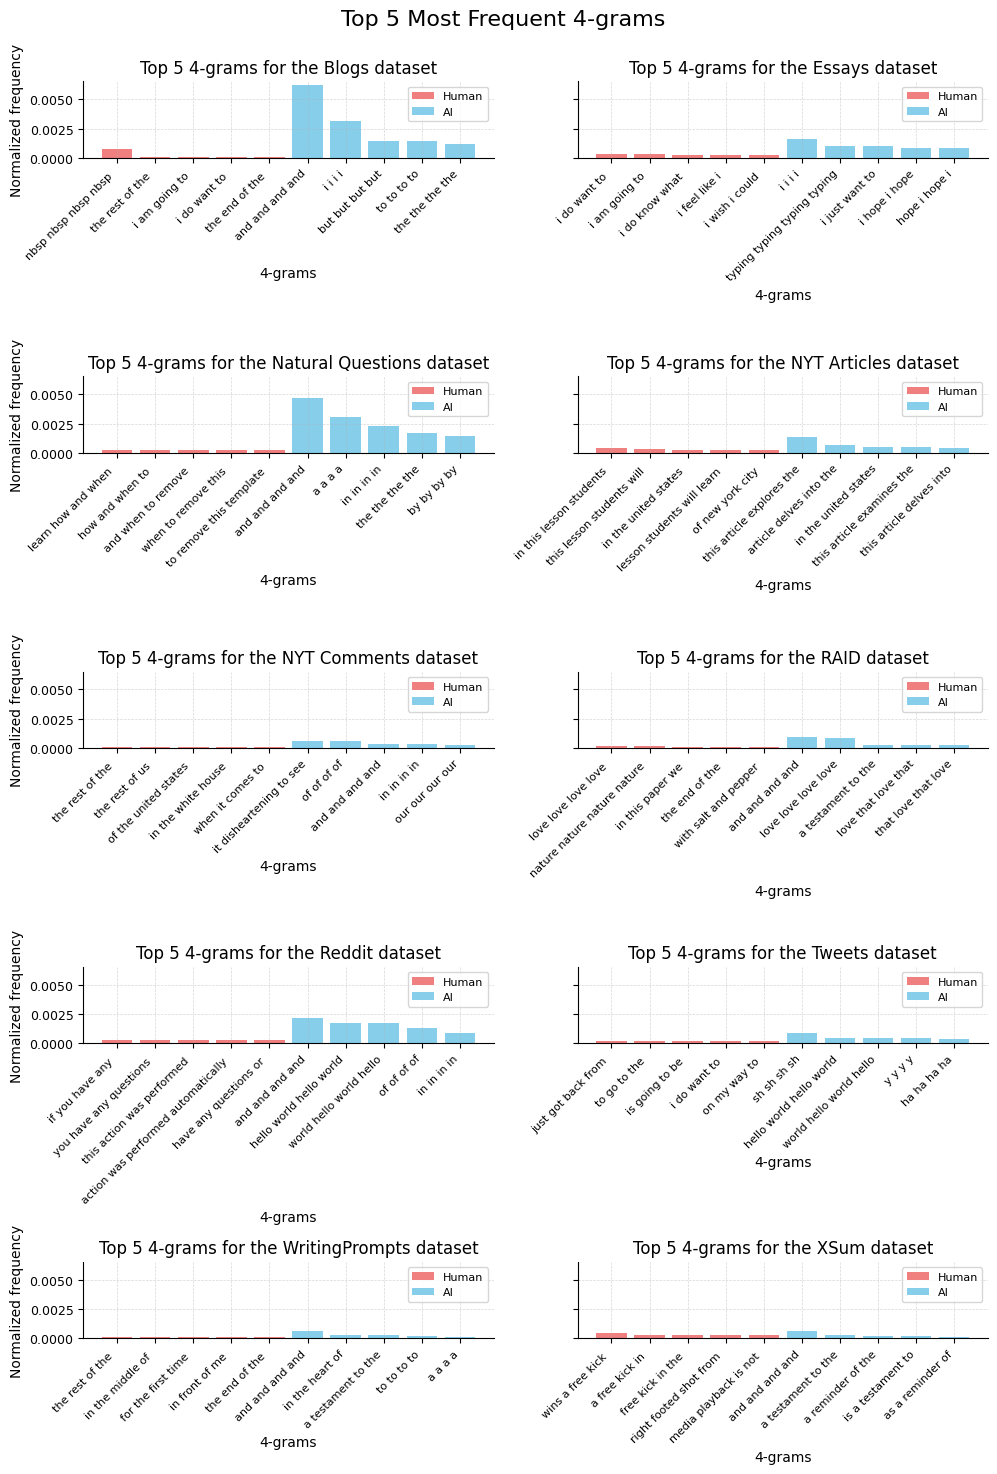

In [108]:
n = 4
fig, axes = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    
    tmp1 = df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 1)]
    tmp1["normalized_frequency"] = tmp1["frequency"] / tmp1["total_ngrams"]
    tmp1 = tmp1.nlargest(5, "normalized_frequency")
    tmp1["ngram"] = tmp1["ngram"]  + " "

    tmp2 = df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)].groupby("ngram").sum().reset_index()
    tmp2["normalized_frequency"] = tmp2["frequency"] / (df[(df["data"] == datas[i]) & (df["n"] == n) & (df["is_human"] == 0)]["total_ngrams"].sum() / 10)
    tmp2 = tmp2.nlargest(5, "normalized_frequency")
    tmp = pd.concat([tmp1, tmp2], ignore_index=True)
    colors = tmp['is_human'].map({0: 'skyblue', 1: 'lightcoral'})

    ax.bar(tmp['ngram'], tmp['normalized_frequency'], color=colors)
    ax.set_title(f"Top 5 {n}-grams for the {datas_names[i]} dataset", fontsize=12)
    ax.set_xlabel(f"{n}-grams", fontsize=10)
    ax.set_xticks(range(len(tmp['ngram'])))  # Ensure ticks match bar positions
    ax.set_xticklabels(tmp['ngram'], rotation=45, ha='right', fontsize=8)
    if i % 2 == 0:
        ax.set_ylabel("Normalized frequency", fontsize=10)
        ax.tick_params(axis='y', labelsize=9)
    
    ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    legend_elements = [
        Patch(facecolor='lightcoral', label='Human'),
        Patch(facecolor='skyblue', label='AI')
    ]
    ax.legend(handles=legend_elements, fontsize=8, loc='upper right')

fig.suptitle(f"Top 5 Most Frequent {n}-grams", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()